# **Лабораторная работа 5**
## Ансамбли моделей машинного обучения. Часть 1.

---

Цель лабораторной работы: изучение ансамблей моделей машинного обучения.

Задание:

  - Выберите набор данных (датасет) для решения задачи классификации или регресии.
  - В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
  - С использованием метода train_test_split разделите выборку на обучающую и тестовую.
  - Обучите следующие ансамблевые модели:
- две модели группы бэггинга (бэггинг или случайный лес или сверхслучайные деревья);
- AdaBoost;
- градиентный бустинг.

Оцените качество моделей с помощью одной из подходящих для задачи метрик.

Сравните качество полученных моделей.

---

# Ход работы

Для выполнения работы выберем датасет *Heart Failure Prediction Dataset*.
Просмотрим датасет, выполним кодирование категориальных признаков, если такие присутствуют. А также проверим его на пропуски.


In [ ]:
import pandas as pd

df = pd.read_csv("heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
df.isnull().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


In [ ]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("Категориальные признаки:")
print(categorical_cols.tolist())


Категориальные признаки:
['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [ ]:
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")


Sex: ['M' 'F']
ChestPainType: ['ATA' 'NAP' 'ASY' 'TA']
RestingECG: ['Normal' 'ST' 'LVH']
ExerciseAngina: ['N' 'Y']
ST_Slope: ['Up' 'Flat' 'Down']


Закодируем категориальные признаки. Label Encoding для Sex и ExerciseAngina. Для остальных сделаем One-Hot Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()


le = LabelEncoder()
df_encoded['Sex'] = le.fit_transform(df_encoded['Sex'])
df_encoded['ExerciseAngina'] = le.fit_transform(df_encoded['ExerciseAngina'])
df_encoded = pd.get_dummies(df_encoded, columns=['ChestPainType', 'RestingECG', 'ST_Slope'])

df_encoded.head()


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,0,False,True,False,False,False,True,False,False,False,True
1,49,0,160,180,0,156,0,1.0,1,False,False,True,False,False,True,False,False,True,False
2,37,1,130,283,0,98,0,0.0,0,False,True,False,False,False,False,True,False,False,True
3,48,0,138,214,0,108,1,1.5,1,True,False,False,False,False,True,False,False,True,False
4,54,1,150,195,0,122,0,0.0,0,False,False,True,False,False,True,False,False,False,True


In [ ]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop("HeartDisease", axis=1)
y = df_encoded["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Обучение BaggingClassifier (на деревьях решений)

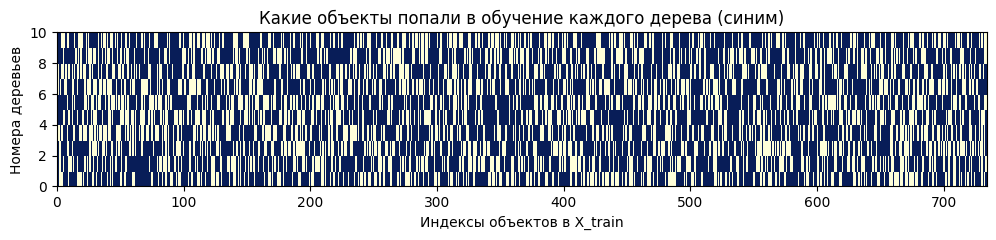

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=10,
    random_state=42
)

bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)

n_estimators = len(bagging_model.estimators_samples_)
n_samples = len(X_train)

# Бинарный массив: 1, если объект с таким индексом попал в обучение дерева i
bin_array = np.zeros((n_estimators, n_samples), dtype=int)

for i, sample_indices in enumerate(bagging_model.estimators_samples_):
    # np.unique нужен, чтобы не учитывать дубликаты в бутстрэп-подвыборке
    bin_array[i, np.unique(sample_indices)] = 1

# Визуализация
fig, ax = plt.subplots(figsize=(12, 2))
ax.pcolor(bin_array, cmap='YlGnBu')
ax.set_xlabel('Индексы объектов в X_train')
ax.set_ylabel('Номера деревьев')
plt.title('Какие объекты попали в обучение каждого дерева (синим)')
plt.show()



In [ ]:

for i in range(5):
    included_mask = bin_array[i]  # Массив из 0 и 1: 1 — объект был в обучении, 0 — нет
    n_total = len(included_mask)
    n_oob = np.sum(included_mask == 0)
    oob_ratio = n_oob / n_total
    print(f'Для дерева №{i+1} размер OOB составляет {oob_ratio:.2%}')


Для дерева №1 размер OOB составляет 36.92%
Для дерева №2 размер OOB составляет 36.38%
Для дерева №3 размер OOB составляет 37.87%
Для дерева №4 размер OOB составляет 37.87%
Для дерева №5 размер OOB составляет 36.65%


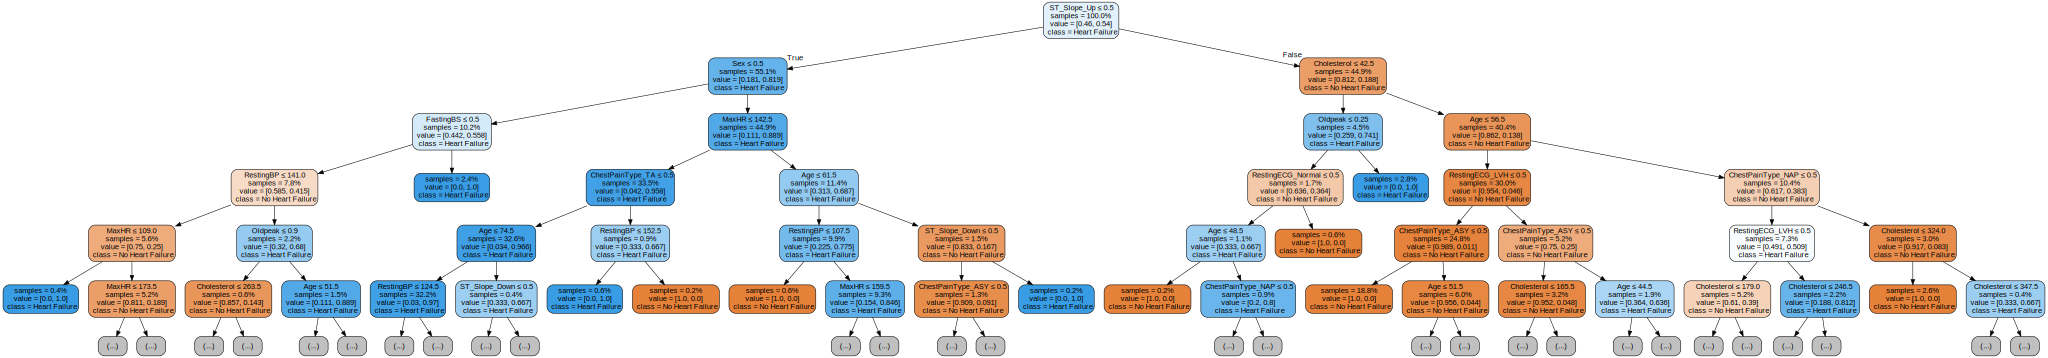

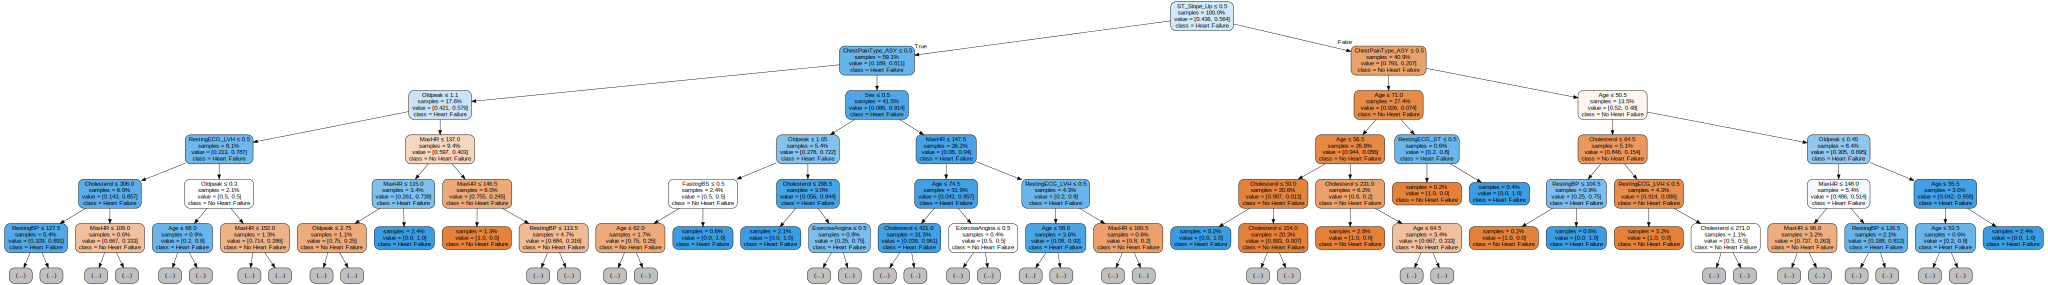

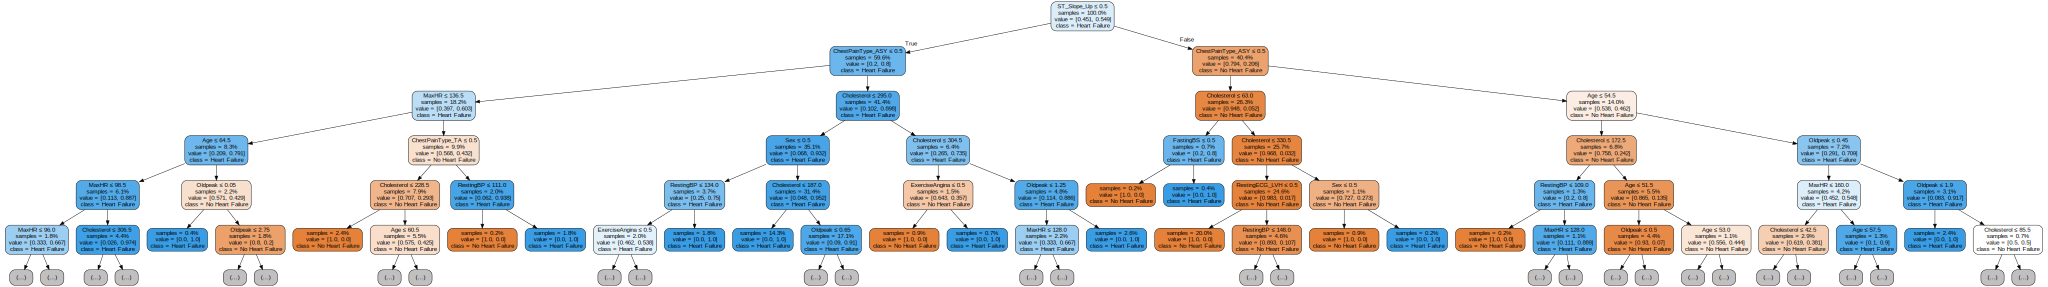

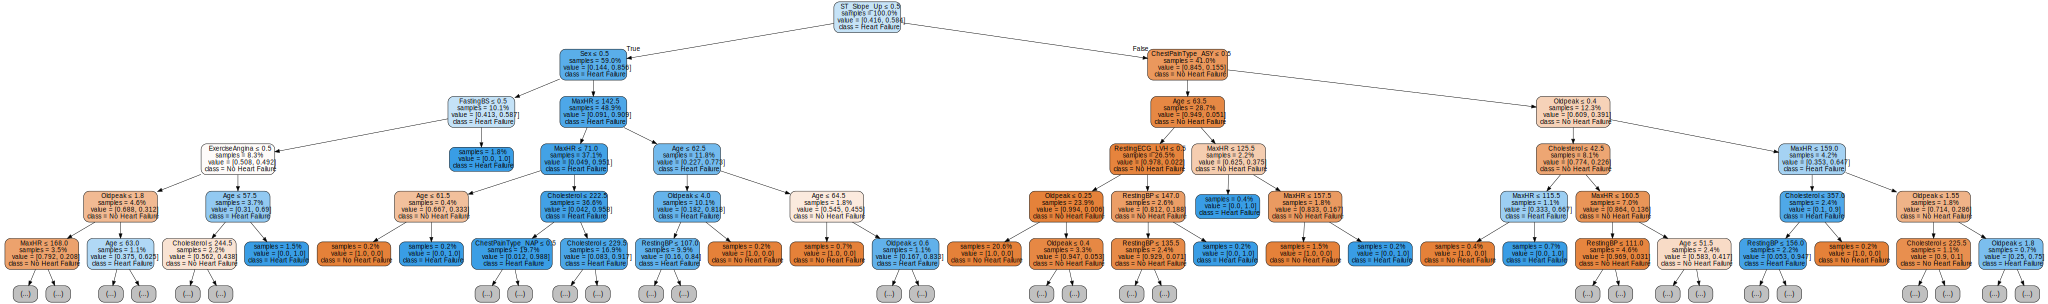

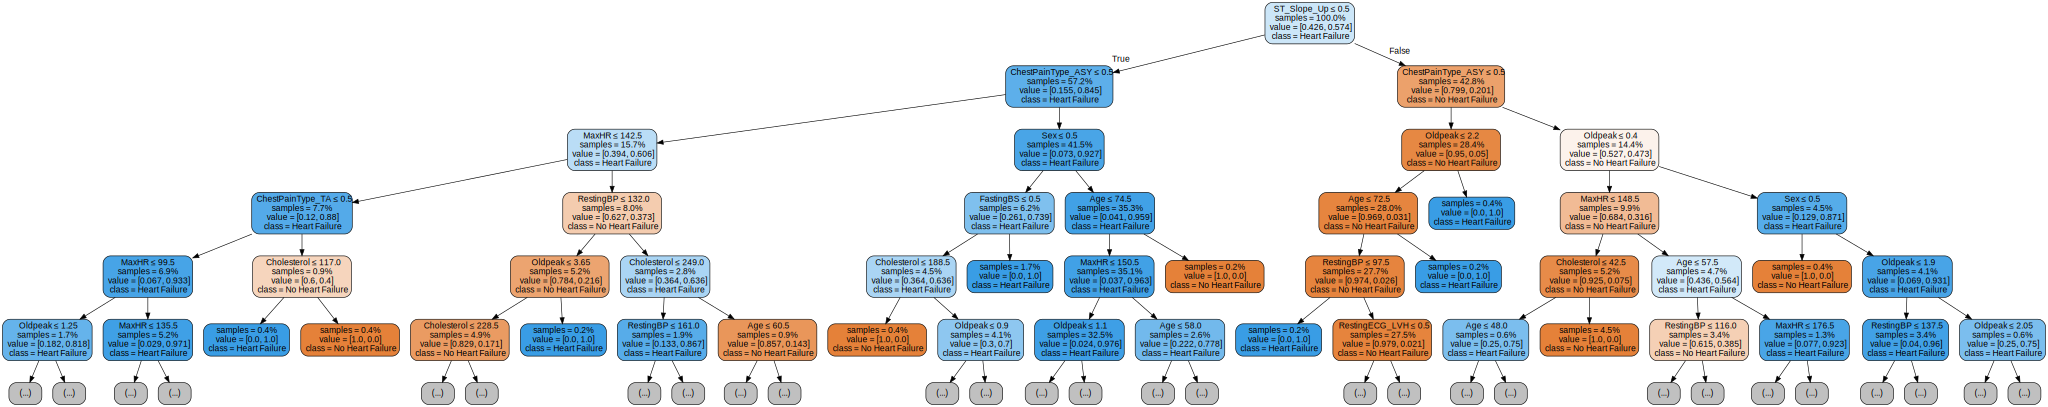

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display

def visualize_tree_small(tree_model, feature_names, class_names):
    dot_data = export_graphviz(
        tree_model,
        out_file=None,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        special_characters=True,
        proportion=True,
        impurity=False,
        max_depth=5  # Ограничиваем глубину для ком пактности
    )

    graph = graphviz.Source(dot_data)
    return graph

# Визуализация первых 3 деревьев (для наглядности)
for i in range(5):
    tree = bagging_model.estimators_[i]
    graph = visualize_tree_small(tree,
                               feature_names=X_train.columns,
                               class_names=["No Heart Failure", "Heart Failure"])
    display(graph)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


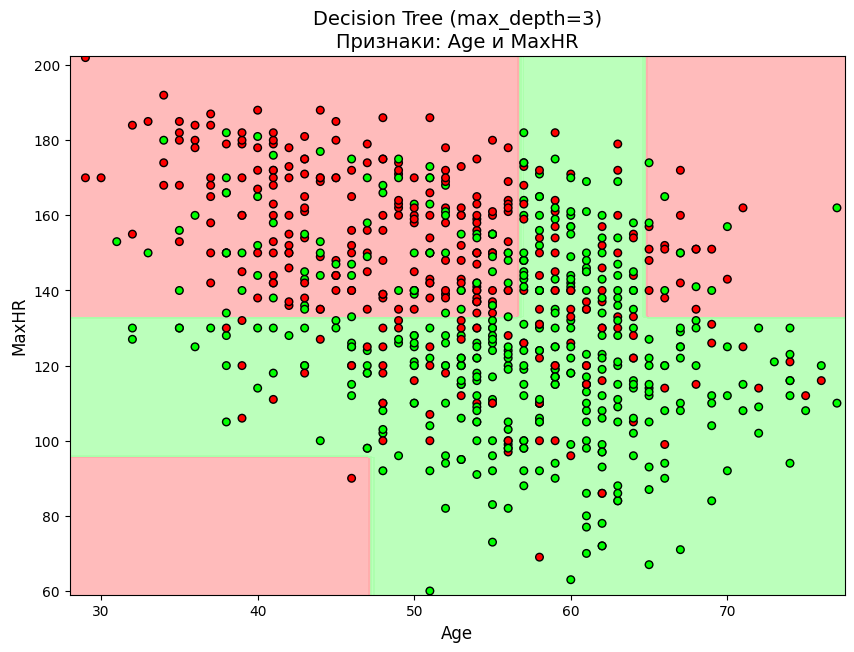

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


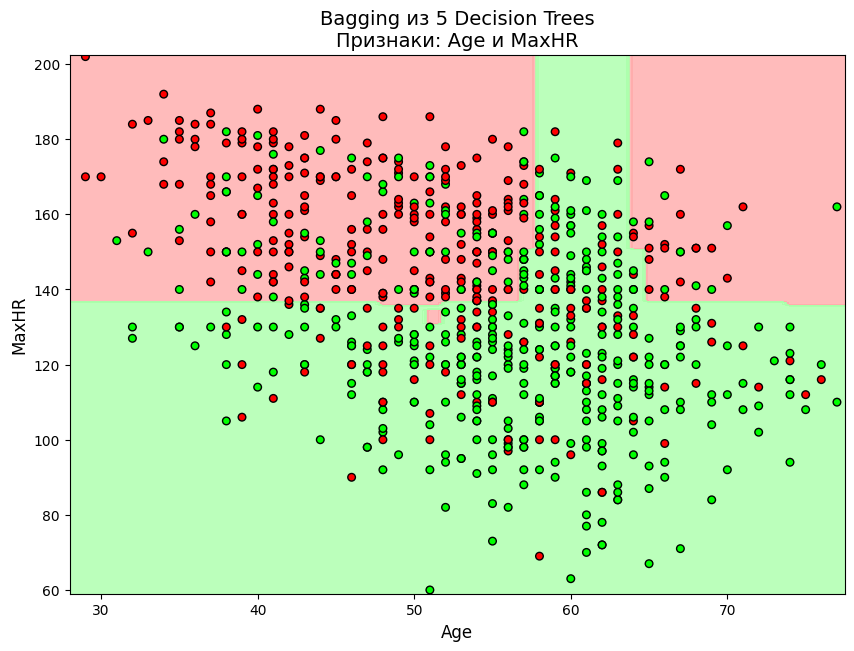

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

def plot_cl(estimator, X, y, title=None):
    """
    Визуализация границ решений классификатора.

    Параметры:
    estimator - модель классификатора
    X - DataFrame с двумя признаками
    y - целевая переменная
    title - заголовок графика
    """
    if X.shape[1] != 2:
        raise ValueError("Функция работает только с 2 признаками")

    # Создаем сетку для построения границ
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5),  # Увеличили шаг для скорости
                         np.arange(y_min, y_max, 0.5))

    # Обучаем модель и делаем предсказания для сетки
    estimator.fit(X, y)
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Цветовая карта (2 класса)
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

    # Построение графика
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)

    # Отображение обучающих точек
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=30)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    if title:
        plt.title(title, fontsize=14)
    else:
        plt.title(f"Границы решений {estimator.__class__.__name__}", fontsize=14)

    plt.xlabel(X.columns[0], fontsize=12)
    plt.ylabel(X.columns[1], fontsize=12)
    plt.show()

# Выбираем 2 числовых признака из доступных
selected_features = ['Age', 'MaxHR']  # Возраст и Максимальный сердечный ритм

# 1. Визуализация для Decision Tree
plot_cl(DecisionTreeClassifier(random_state=42, max_depth=3),
        X_train[selected_features],
        y_train,
        "Decision Tree (max_depth=3)\nПризнаки: Age и MaxHR")

# 2. Визуализация для Bagging Classifier
plot_cl(BaggingClassifier(DecisionTreeClassifier(random_state=42, max_depth=3),
                         n_estimators=5),
        X_train[selected_features],
        y_train,
        "Bagging из 5 Decision Trees\nПризнаки: Age и MaxHR")

Обучение RandomForestClassifier

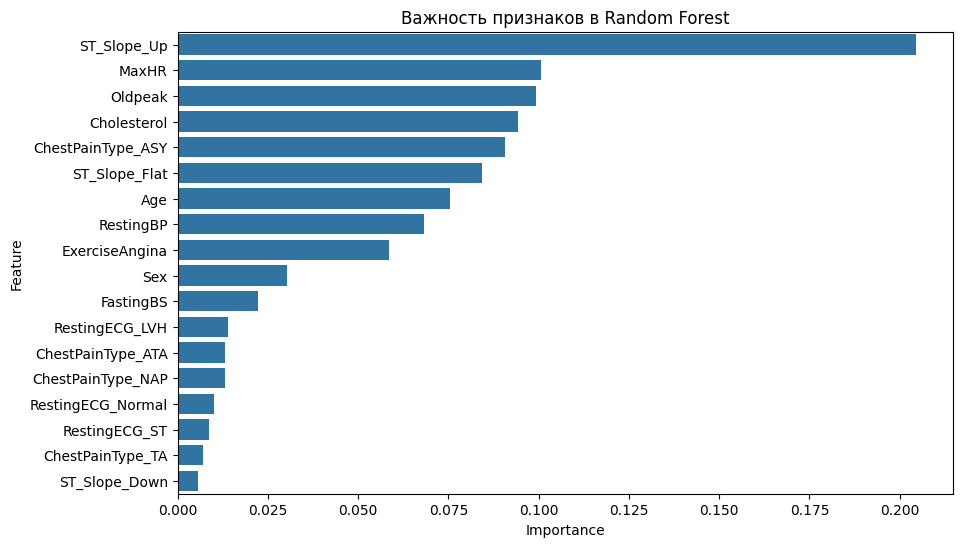

In [ ]:
# Визуализация важности признаков
import pandas as pd
import seaborn as sns

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Важность признаков в Random Forest')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


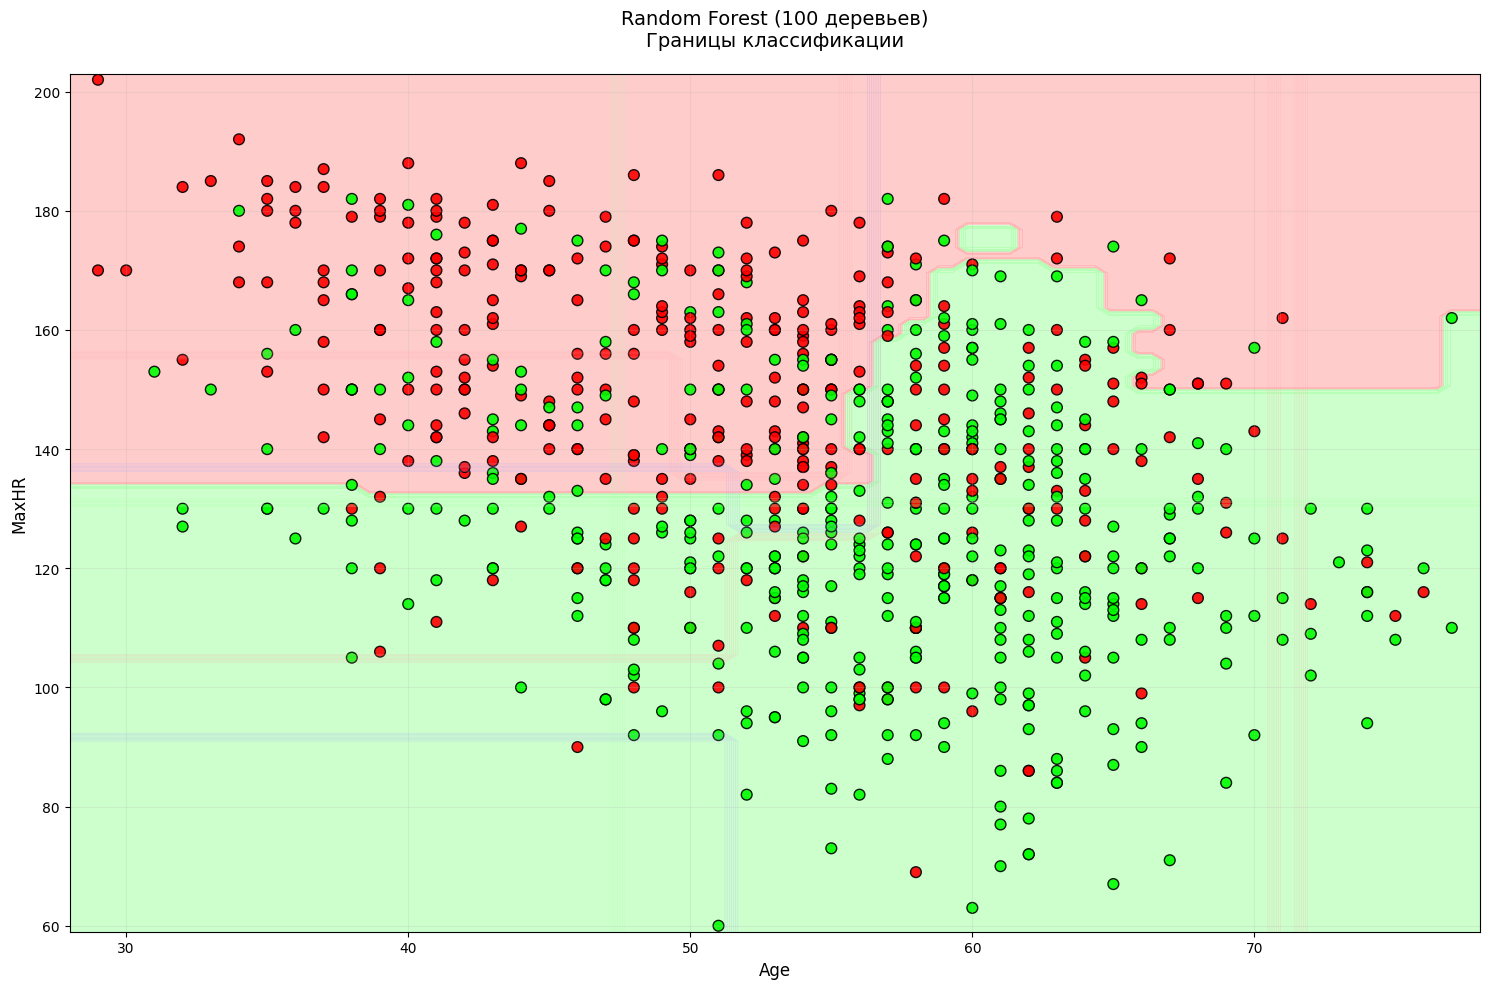

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestClassifier

def plot_classification_results(model, X, y, title=None):

    # Сетка для построения границ
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Предсказания основной модели
    model.fit(X, y)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Цветовая схема
    colors = ['#FFAAAA', '#AAFFAA', '#AAAAFF']
    cmap_light = ListedColormap(colors[:len(np.unique(y))])
    cmap_bold = ListedColormap([c.replace('AA', '00') for c in colors[:len(np.unique(y))]])

    # Создаем график
    plt.figure(figsize=(15, 10))

    # 1. Отображаем границы решений
    plt.contourf(xx, yy, Z, alpha=0.6, cmap=cmap_light)

    # 2. Отображаем обучающие точки
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=60, alpha=0.9)

    # 3. Добавляем предсказания отдельных деревьев (опционально)
    for i, tree in enumerate(model.estimators_[:5]):  # Первые 5 деревьев
        Z_tree = tree.predict(np.c_[xx.ravel(), yy.ravel()])
        plt.contour(xx, yy, Z_tree.reshape(xx.shape),
                    colors=[colors[i%3]], linewidths=0.5, alpha=0.3)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    title = title or f"Границы решений {model.__class__.__name__}\nПризнаки: {X.columns[0]} и {X.columns[1]}"
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel(X.columns[0], fontsize=12)
    plt.ylabel(X.columns[1], fontsize=12)


    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

# Выбираем 2 наиболее важных признака (пример для Heart Failure)
selected_features = ['Age', 'MaxHR']  # Замените на актуальные для ваших данных

# Создаем и обучаем Random Forest
rf_model = RandomForestClassifier(n_estimators=100,
                                 max_depth=3,  # Для лучшей визуализации
                                 random_state=42)
rf_model.fit(X_train[selected_features], y_train)

# Визуализация
plot_classification_results(rf_model,
                          X_train[selected_features],
                          y_train,
                          title="Random Forest (100 деревьев)\nГраницы классификации")

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Границы решений AdaBoost:


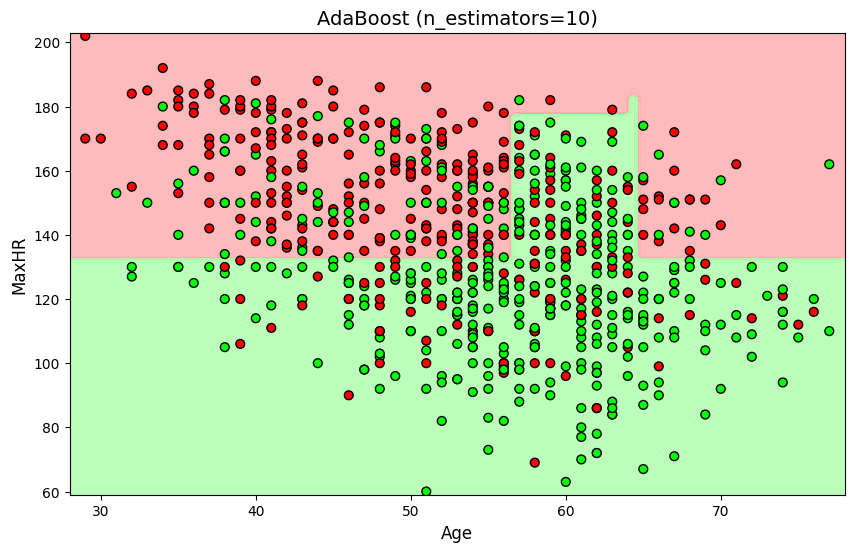


Первые 2 дерева ансамбля:


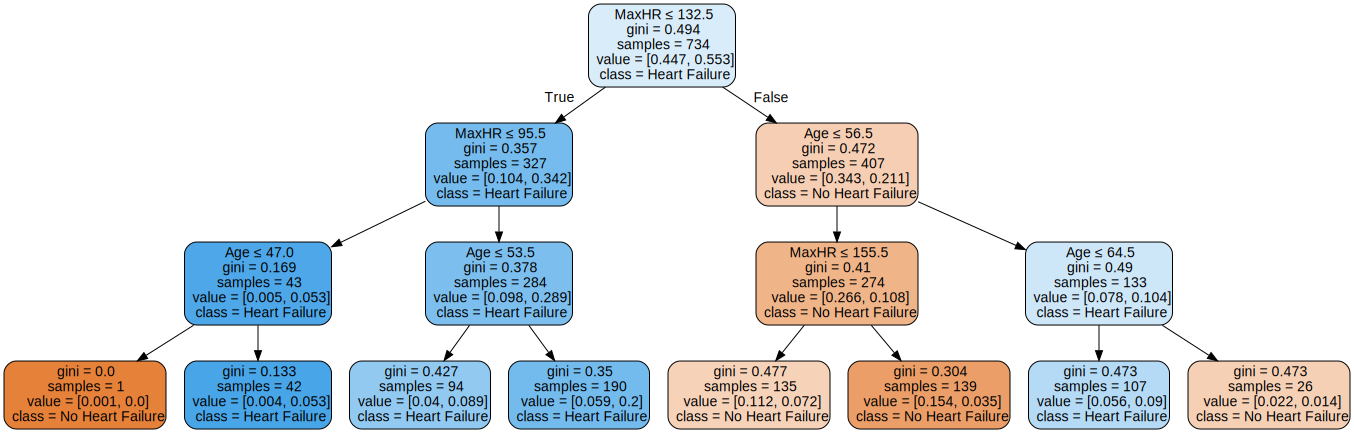

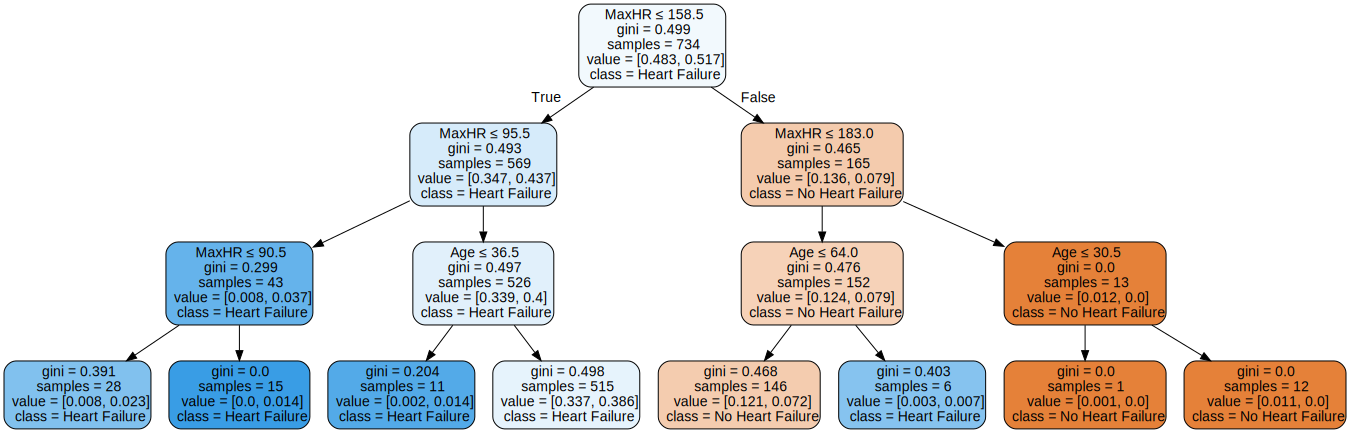

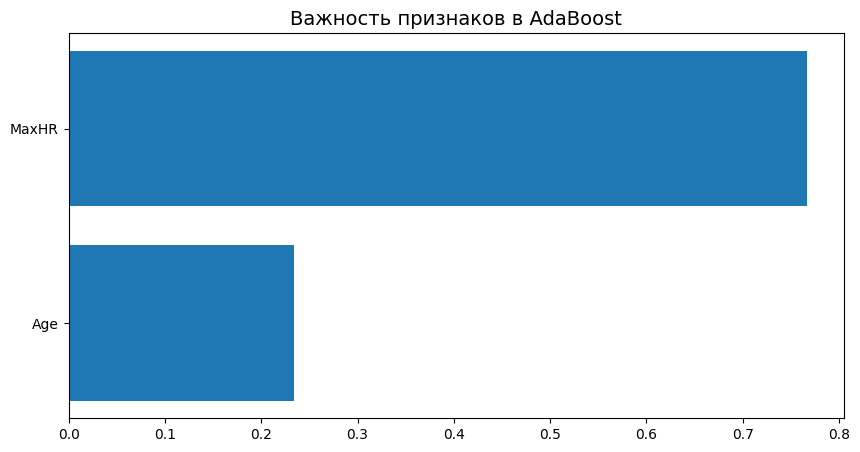

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from IPython.display import display

# 1. Функция для визуализации границ решений
def plot_ada_boundary(model, X, y, title=None):
    """
    Визуализация границ решений AdaBoost
    """
    # Создаем сетку
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Предсказания
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Цветовая схема
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

    # Построение графика
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=40)
    plt.title(title or f"AdaBoost (n_estimators={model.n_estimators})", fontsize=14)
    plt.xlabel(X.columns[0], fontsize=12)
    plt.ylabel(X.columns[1], fontsize=12)
    plt.show()

# 2. Функция для визуализации деревьев
def plot_ada_tree(tree, feature_names, class_names, tree_idx):
    dot_data = export_graphviz(
        tree,
        out_file=None,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    display(graph)
    # Для сохранения: graph.render(f'ada_tree_{tree_idx}', format='png')

# 3. Создаем и обучаем AdaBoost (исправленный вариант)
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=10,
    algorithm='SAMME',  # Используем SAMME вместо SAMME.R
    random_state=42
)

# Выбираем 2 признака (пример для Heart Failure)
features = ['Age', 'MaxHR']  # Замените на актуальные

# Обучение
ada.fit(X_train[features], y_train)

# Визуализация
print("Границы решений AdaBoost:")
plot_ada_boundary(ada, X_train[features], y_train)

print("\nПервые 2 дерева ансамбля:")
for i in range(2):
    plot_ada_tree(ada.estimators_[i],
                 features,
                 ["No Heart Failure", "Heart Failure"],
                 i+1)

# Важность признаков
plt.figure(figsize=(10, 5))
plt.barh(features, ada.feature_importances_)
plt.title("Важность признаков в AdaBoost", fontsize=14)
plt.show()

In [ ]:
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay

# Предсказание на тестовых данных
y_pred_ada = ada.predict(X_test[features])

# Оценка F1-score
f1 = f1_score(y_test, y_pred_ada)
print(f"F1-score AdaBoost: {f1:.4f}\n")


F1-score AdaBoost: 0.7291



<Figure size 1000x600 with 0 Axes>

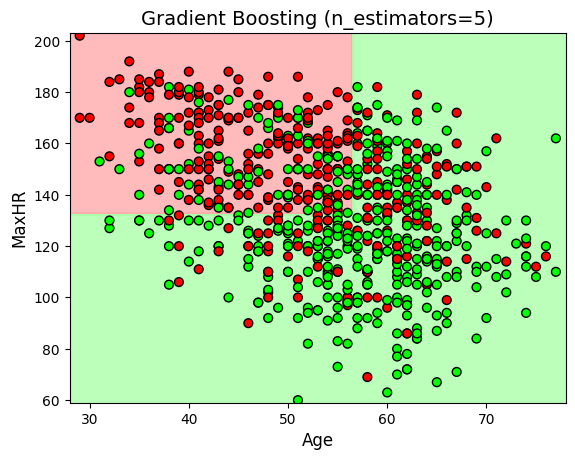

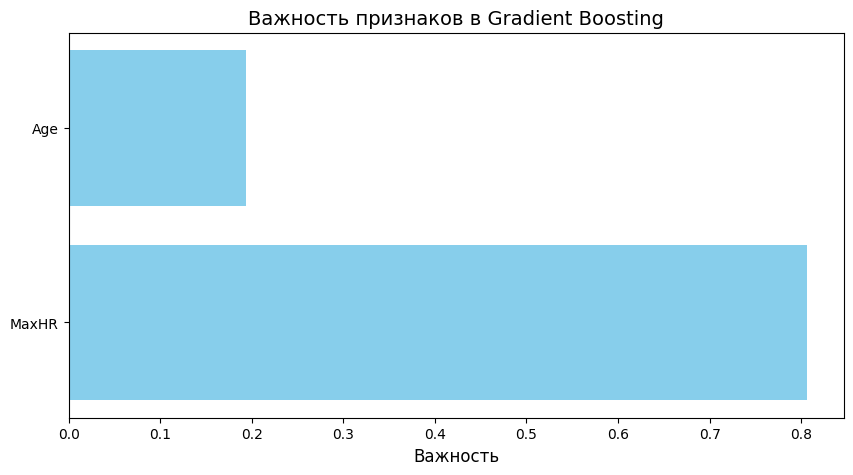

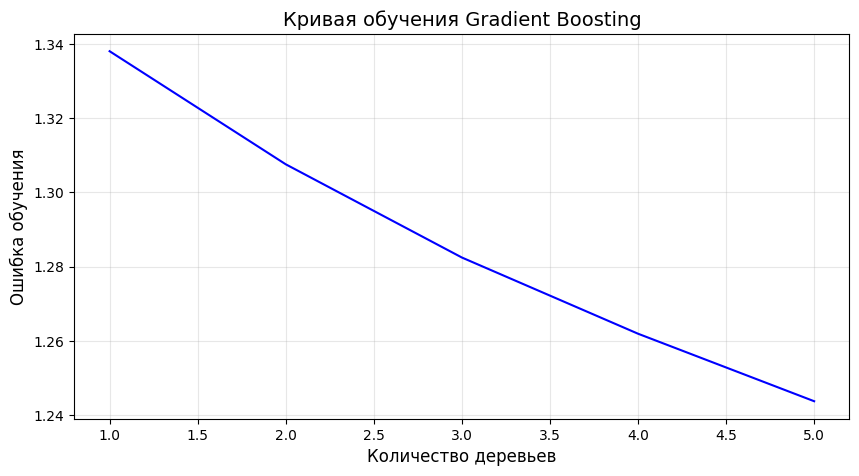

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

# 1. Инициализация и обучение Gradient Boosting
gb_model = GradientBoostingClassifier(
    n_estimators=5,  # Количество деревьев
    learning_rate=0.1,  # Темп обучения
    max_depth=2,       # Глубина деревьев
    random_state=42
)

# Выбираем 2 признака для визуализации
features = ['Age', 'MaxHR']  # Замените на нужные признаки
gb_model.fit(X_train[features], y_train)


# 3. Визуализация границ решений
plt.figure(figsize=(10, 6))
DecisionBoundaryDisplay.from_estimator(
    gb_model,
    X_train[features],
    cmap=ListedColormap(['#FFAAAA', '#AAFFAA']),
    alpha=0.8,
    response_method='predict'
)
plt.scatter(X_train[features[0]], X_train[features[1]],
            c=y_train, cmap=ListedColormap(['#FF0000', '#00FF00']),
            edgecolor='k', s=40)
plt.title(f"Gradient Boosting (n_estimators={gb_model.n_estimators})", fontsize=14)
plt.xlabel(features[0], fontsize=12)
plt.ylabel(features[1], fontsize=12)
plt.show()

# 4. Важность признаков
plt.figure(figsize=(10, 5))
importances = gb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title("Важность признаков в Gradient Boosting", fontsize=14)
plt.barh(range(len(features)), importances[indices], color='skyblue', align='center')
plt.yticks(range(len(features)), np.array(features)[indices])
plt.xlabel("Важность", fontsize=12)
plt.show()

# 5. Кривая обучения (ошибка на каждой итерации)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(gb_model.n_estimators) + 1, gb_model.train_score_, 'b-')
plt.title("Кривая обучения Gradient Boosting", fontsize=14)
plt.xlabel("Количество деревьев", fontsize=12)
plt.ylabel("Ошибка обучения", fontsize=12)
plt.grid(alpha=0.3)
plt.show()


In [ ]:
from sklearn.metrics import f1_score, classification_report


X_test_bagging = X_test
features = ['Age', 'MaxHR']
X_test_ada = X_test[features]
X_test_gb = X_test[features]
y_pred_bagging = bagging_model.predict(X_test_bagging)
y_pred_ada = ada.predict(X_test_ada)
y_pred_gb = gb_model.predict(X_test_gb)
print("Bagging F1-score:", f1_score(y_test, y_pred_bagging))
print("AdaBoost F1-score:", f1_score(y_test, y_pred_ada))
print("Gradient Boosting F1-score:", f1_score(y_test, y_pred_gb))


Bagging F1-score: 0.8514851485148515
AdaBoost F1-score: 0.729064039408867
Gradient Boosting F1-score: 0.7523809523809524
